In [26]:
system("type R")
library(cacoa)
library(Seurat)
library(magrittr)
library(cowplot)
library(ggplot2)
library(igraph)
library(svglite)
library(enrichplot)
options(repr.plot.width=12, repr.plot.height=10, 
        jupyter.plot_scale = 1,repr.plot.res = 100)
Sys.setenv(https_proxy='http://www-int.dkfz-heidelberg.de:80')
Sys.setenv(http_proxy='http://www-int.dkfz-heidelberg.de:80')
if (exists("snakemake")) {
    cao_input <- snakemake@input[["cacoa_processed"]]
    repermute <- snakemake@params[["permute"]] 
    plot_path <- snakemake@params[["plot_path"]]
    save_plots <- snakemake@config[["save_plots"]]
    threads <- snakemake@threads
} else {
    cao_input <- "/omics/odcf/analysis/OE0228_projects/VascularAging/rna_sequencing/public_scrnaseq/TabularMuris/processed_cao.RDS.gz"
    #cao_input <-  file.path(base_fp, "processed_cao.RDS.gz")
    repermute <- F
    plot_path <- "/omics/odcf/analysis/OE0228_projects/VascularAging/rna_sequencing/public_scrnaseq/TabularMuris/plots"
    save_plots <- FALSE
}


#relevel(cao_obj$sample.groups,"young")

In [29]:
cao_input
cao_obj$data.object


[1] "/omics/odcf/analysis/OE0228_projects/VascularAging/rna_sequencing/public_scrnaseq/TabularMuris/processed_cao.RDS.gz"

An object of class Seurat 
36508 features across 17491 samples within 2 assays 
Active assay: SCT (16648 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

# CACOA Analysis of Public Single Cell Datasets

Using the Cacoa Package we analyze the structure of single cell datasets with 
the goal of identifying group specific changes in the data. 

In [3]:
cao_obj <- readRDS(cao_input)

cao_obj$sample.groups.palette <- c( young = "#FC8D59",
      aged = "#A0A0A4")
group_colors <- c( young = "#FC8D59",
      aged = "#A0A0A4")
cao_obj$plot.theme <- theme_bw()

In [4]:
packageVersion("cacoa")

[1] ‘0.4.0’

In [5]:
example.celltypes <- names(sort(table(cao_obj$cell.groups),decreasing=T))
top1 <- example.celltypes[1] 
top2 <- example.celltypes[c(1,2)]

cells.to.contour <- top2
cell.to.go <- example.celltypes[3]

alpha <- 0.1; size <- 0.1;

## Overview of dataset

UMAP visualization of the dataset stratified by age and by cell types

Classifcaiton into old and young samples is done on a dataset by dataset basis


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots


Warning message:
“`invoke()` is deprecated as of rlang 0.4.0.
Please use `exec()` or `inject()` instead.
This warning is displayed once per session.”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


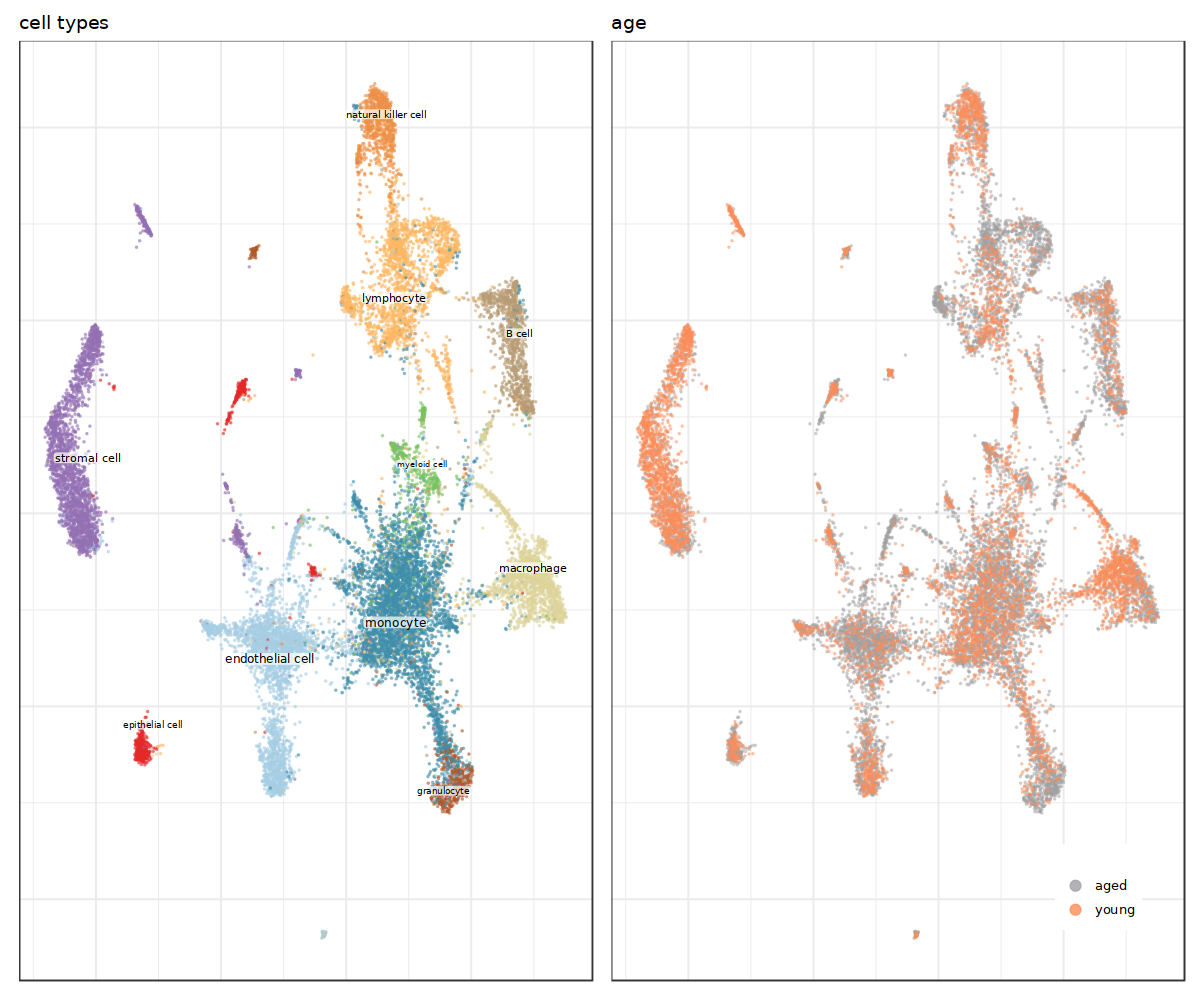

In [6]:
library(ggplot2)
library(patchwork)
size = 0.1
alpha = 0.5
cell_group_umap <- cao_obj$plotEmbedding(color.by='cell.groups', alpha=alpha, size=size, title='cell types', 
                    plot.na=FALSE, show.legend=FALSE, font.size=c(2,3)) 
condition_umap <- cao_obj$plotEmbedding(color.by='condition', alpha=0.4, size=0.1, title='age', mark.groups = F) +    theme(legend.position=c(0.85, 0.1)) +
    guides(color=guide_legend(override.aes = list(size=3,alpha=0.8),title='')) + 
        scale_color_manual(values = group_colors, labels = c("aged" = "aged", "young" = "young"))

if (save_plots) {
    ggsave(filename = "condition_umap.svg" ,condition_umap,path = plot_path, width = 8, height = 8)
    ggsave(filename = "cell_group_umap.svg" ,cell_group_umap,path = plot_path, width = 8, height = 8)
}
cell_group_umap  | condition_umap

In [7]:
names(cao_obj$data.object@graphs)
gc()

#cao_obj$estimateExpressionShiftMagnitudes(dist = "cor", top.n.genes = 1500, n.pcs = NULL)

[1] "SCT_nn"  "SCT_snn"

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,6792137,362.8,10089192,538.9,10089192,538.9
Vcells,693890621,5294.0,974984681,7438.6,706086847,5387.1


## Expresssion Shift Magnitudes

We can use Expression shift magnitudes to infer Intra- and Intercluster differences on the basis of Correlation distances between cells



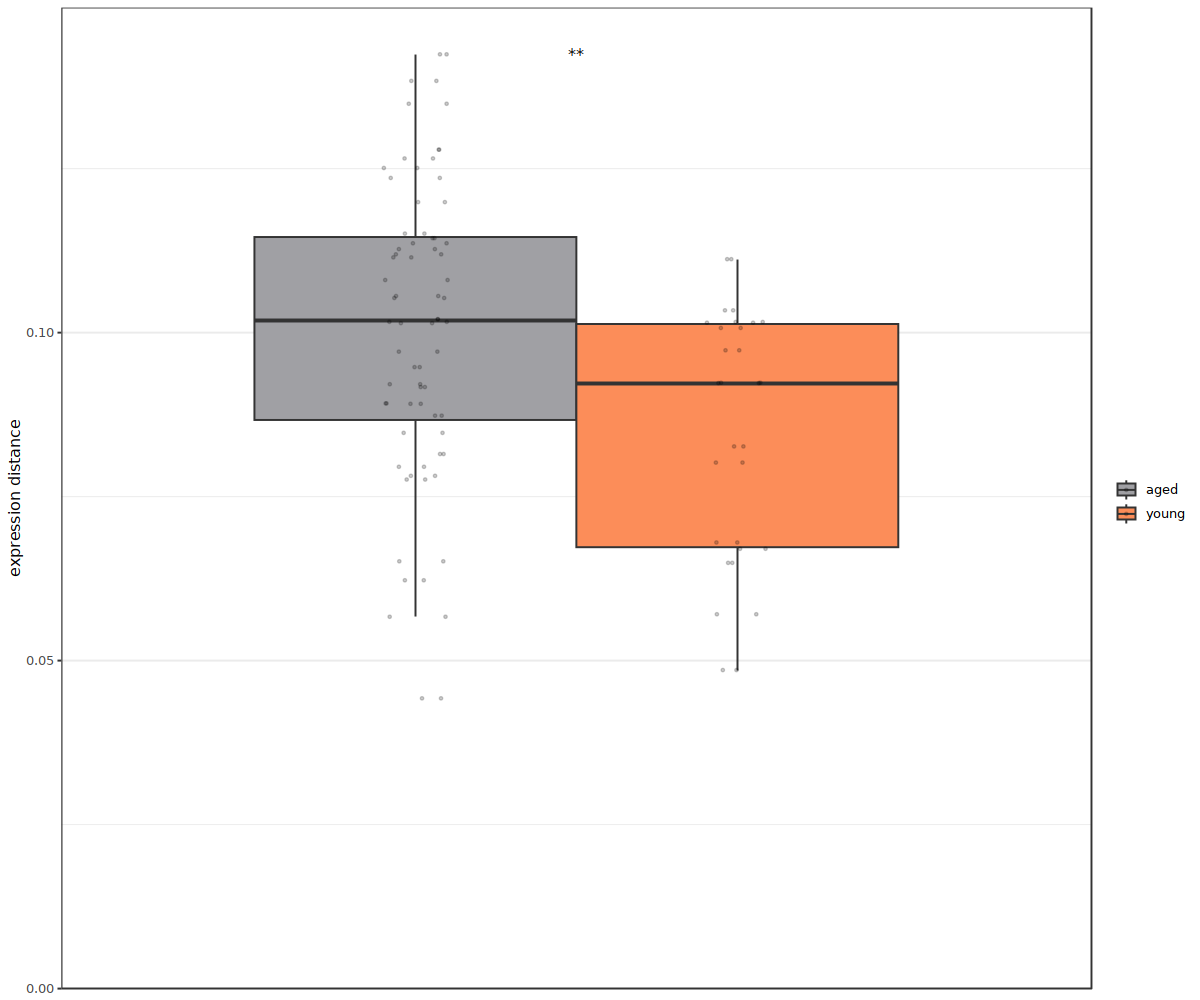

In [8]:
cao_obj$plot.theme <- theme_bw()
joint_expression_dist <- cao_obj$plotExpressionDistance(joint = T, show.significance = T )
if (save_plots) {
    ggsave("joint_expression_dist.svg", joint_expression_dist, path = plot_path, width = 6, height =8)
}
joint_expression_dist 

The following plot whos the Expression distance between groups and tests their significance

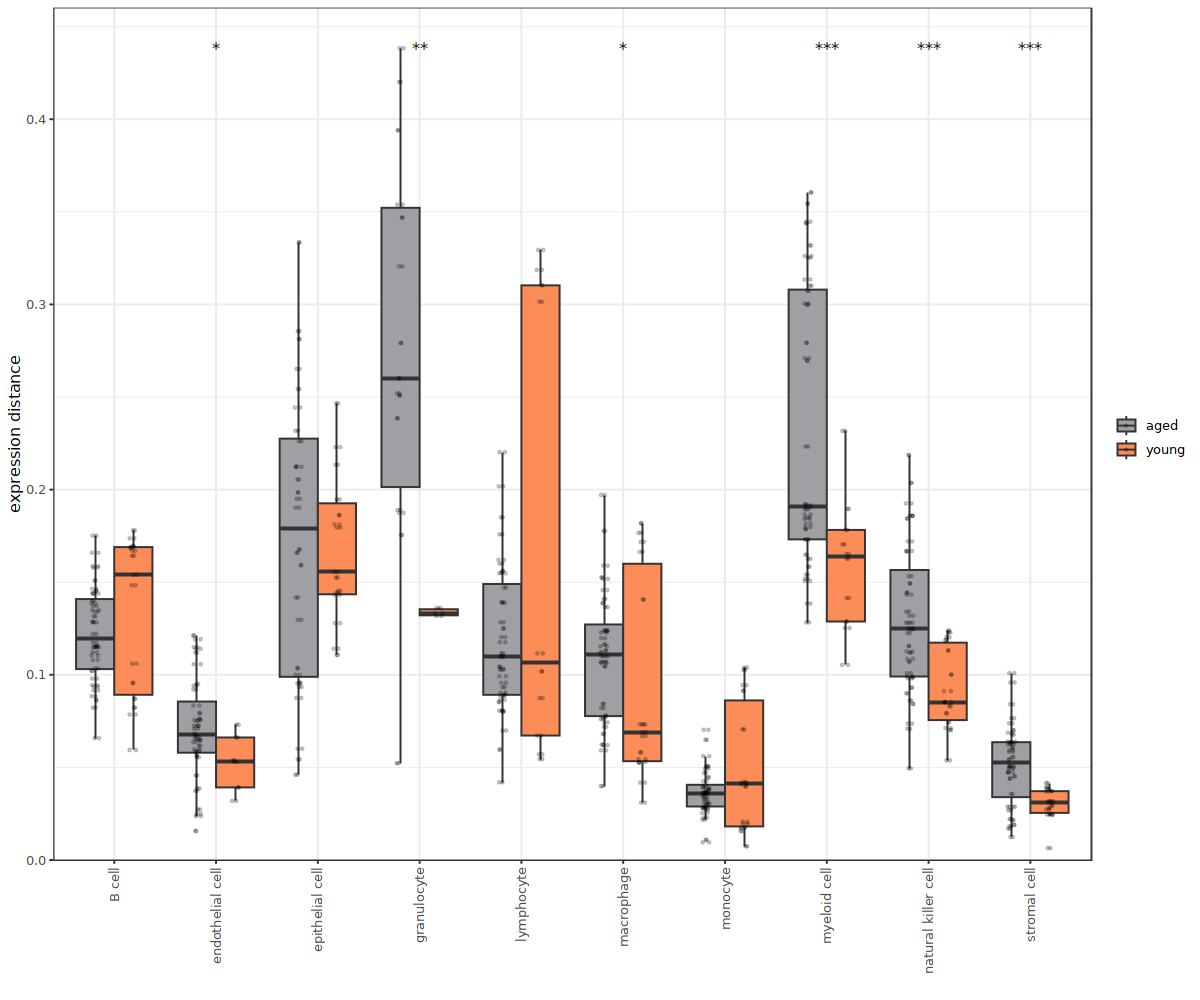

In [9]:
percell_expression_dist <- cao_obj$plotExpressionDistance(show.significance=TRUE,)
if (save_plots) {
    ggsave("expression_dist.svg", percell_expression_dist, path = plot_path, width = 8, height = 8)
}
percell_expression_dist

The Expression distance embedding is a dimensionality reduction on the Correlation distance
between samples showing how samples/batches are related with each other. 

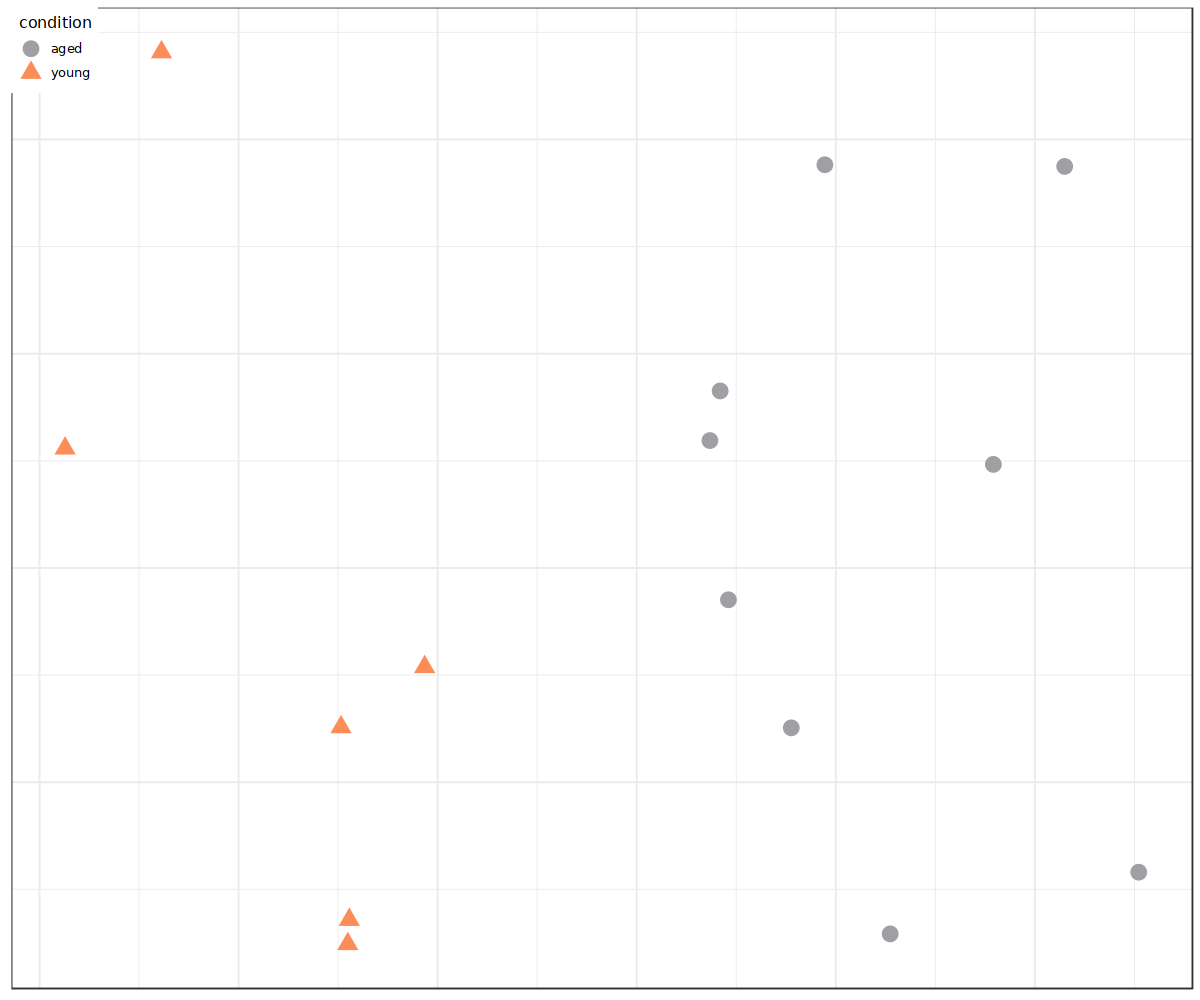

In [10]:
shift_sample_dist<- cao_obj$plotSampleDistances(space  = "expression.shifts", 
  , legend.position=c(0, 1), font.size=NULL ) 

if (save_plots) {
    ggsave(filename = "expression_shift_mds.svg", shift_sample_dist,path = plot_path, width = 8, height = 8)
}
shift_sample_dist 

### Shift types

The first plot here shows the ExpressionshiftMagnitude for "normal" expression shifts

The bottom plot shows this for "common" expression shifts. Difference between these two types is unknown. 


In [11]:
expr_shift_mag <- cao_obj$plotExpressionShiftMagnitudes(type='bar',show.pvalues = "adjusted")

if (save_plots) {
    ggsave("expression_shift_mag.svg", plot = expr_shift_mag, path = plot_path, width = 10, height = 8)
}

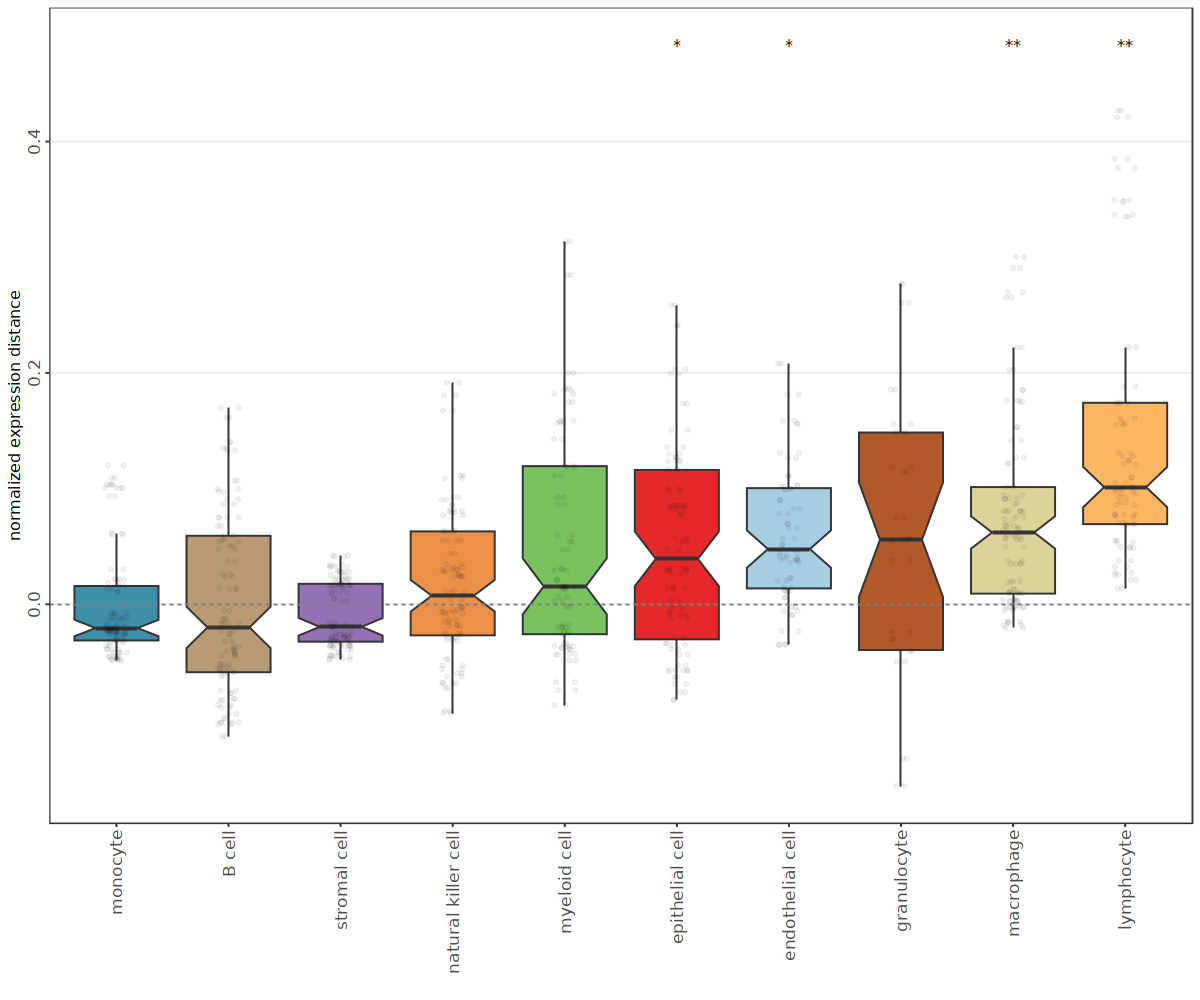

In [12]:
cao_obj$plotExpressionShiftMagnitudes()

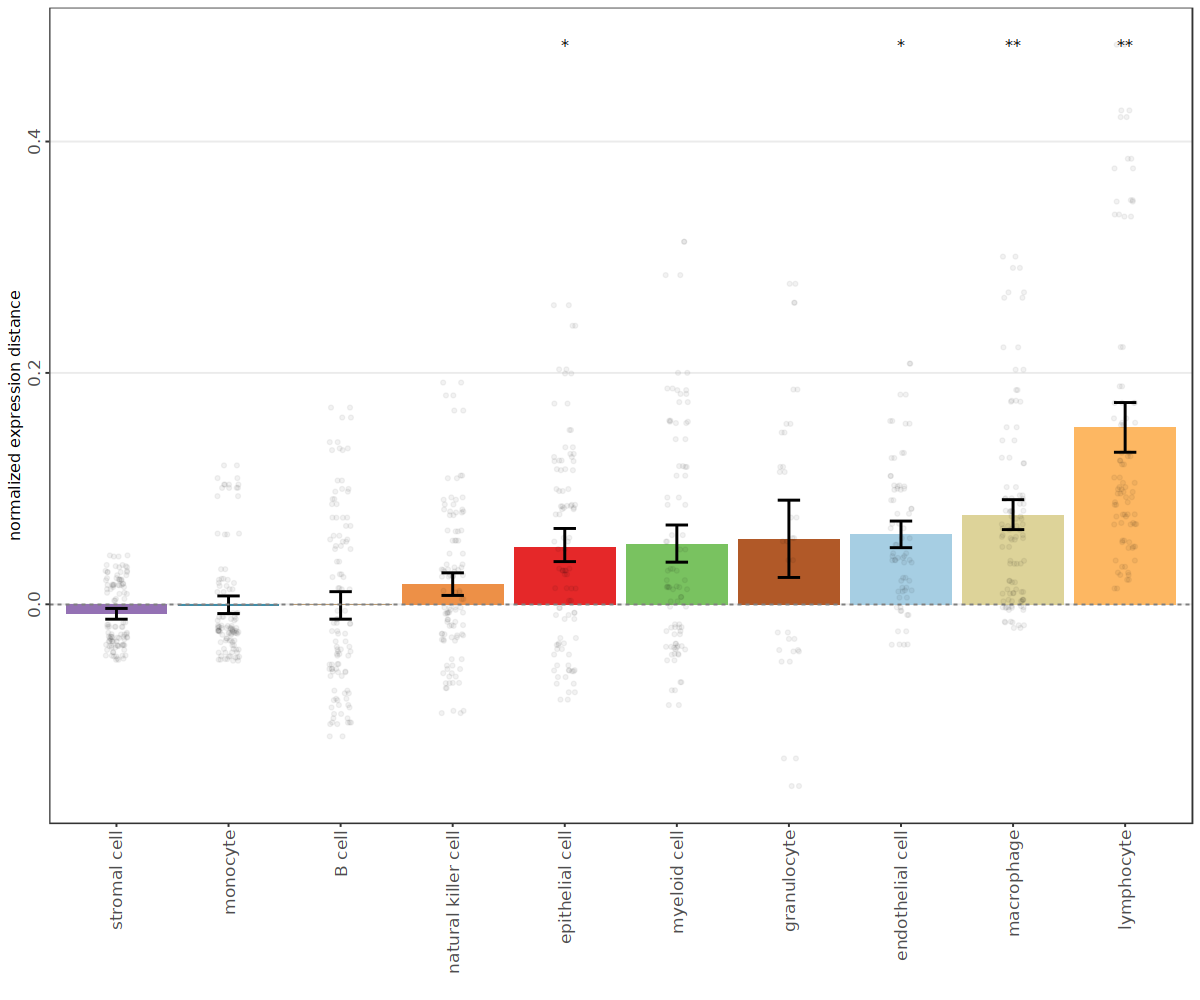

In [13]:
cao_obj$plotExpressionShiftMagnitudes(show.pvalues = "adjusted",
                                        show.jitter=TRUE, type='bar')

## Cell Group Proportions between groups

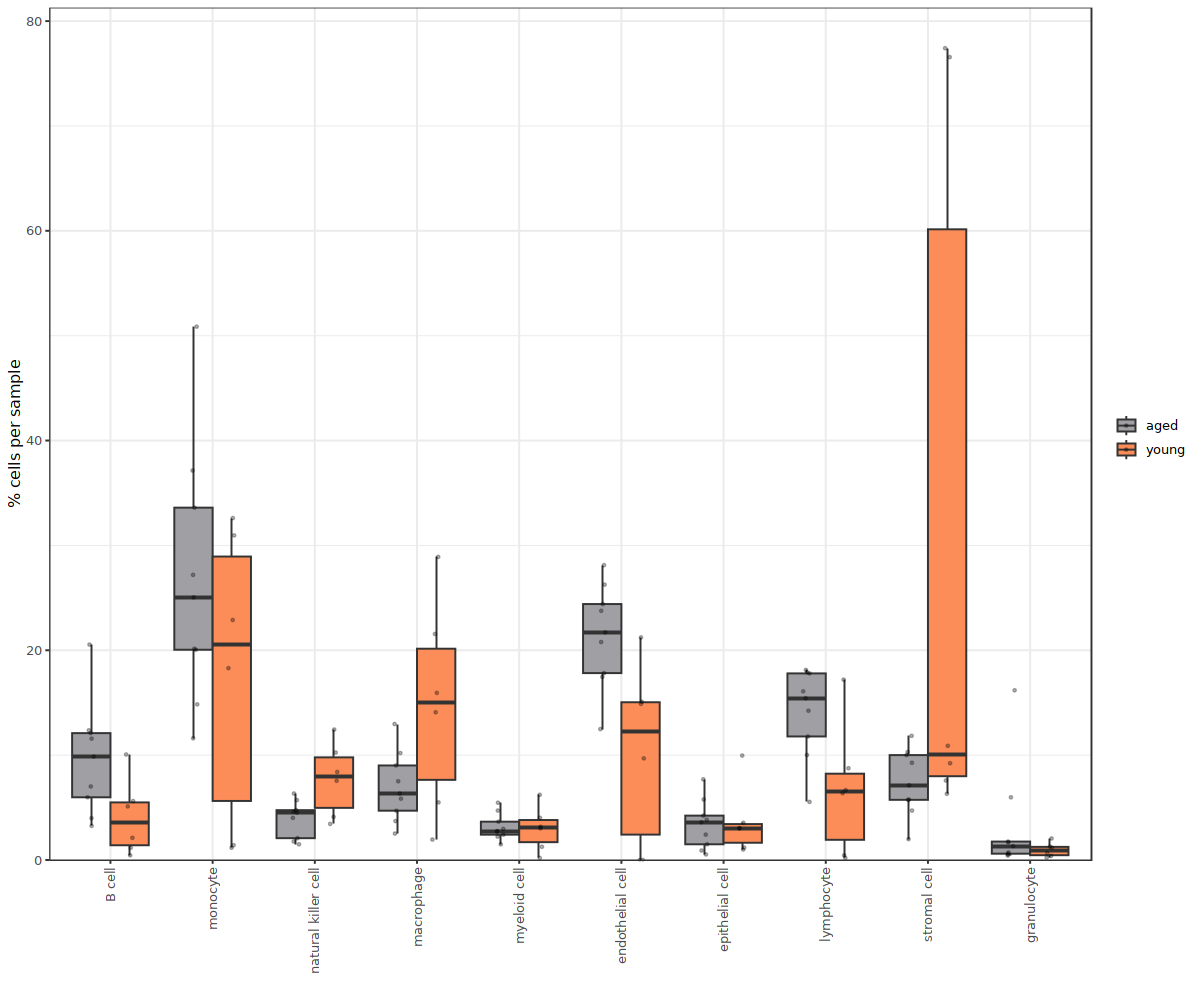

In [14]:
cao_obj$plotCellGroupSizes(alpha=0.3, show.significance=TRUE)

This plot shows PCA? Cell loadings to the best contrast? No Idea what this actually means but its pretty

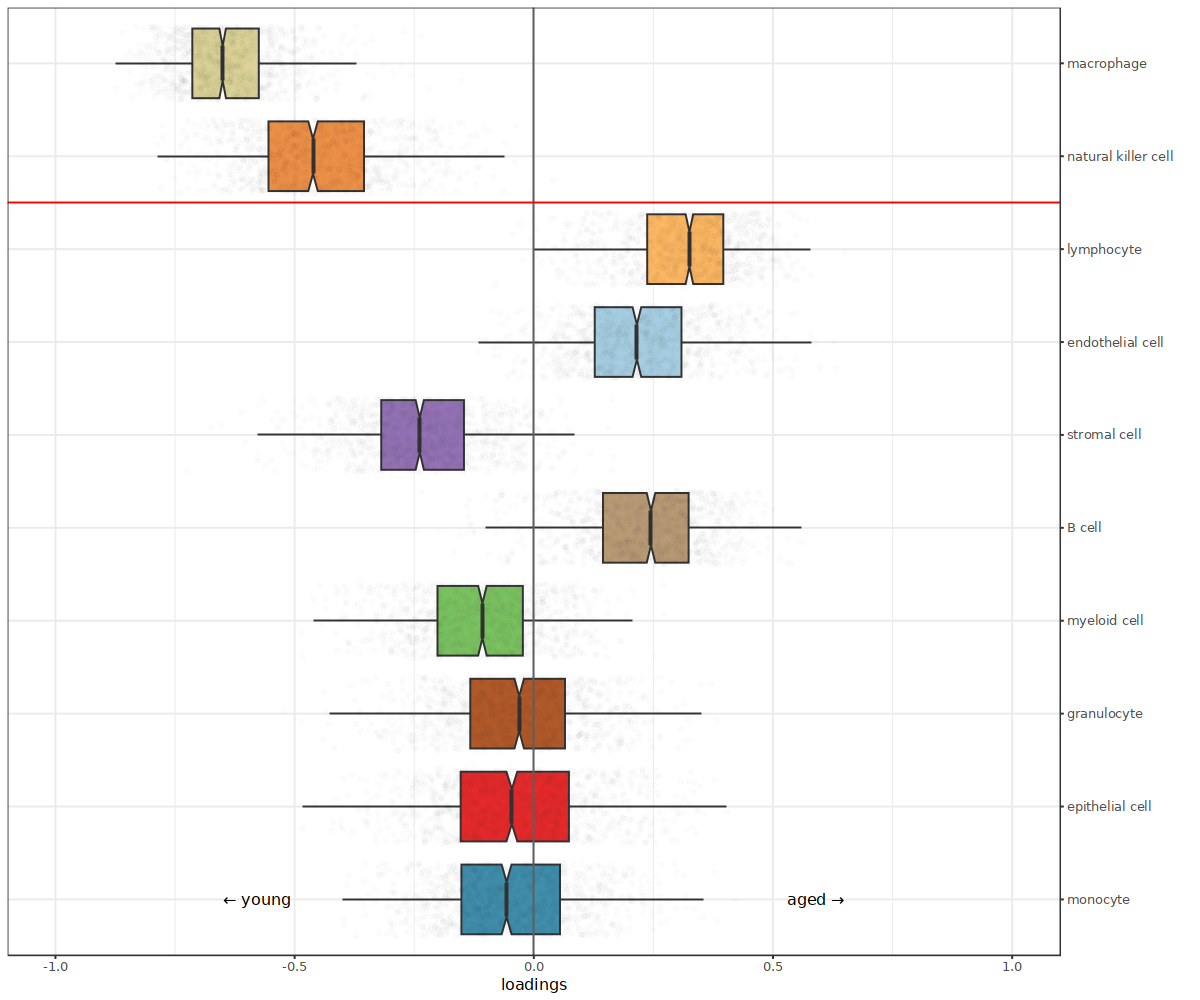

In [15]:
signif.threshold <- 0.05
cao_obj$plotCellLoadings(signif.threshold=signif.threshold, show.pvals=FALSE, alpha=0.01)

## CODA space

Sadly we dont know what CODA space is (some type of Dimensionality Reduction). The first plot is ont he basis of PCA and somehow infers cluster Positions across this PCA (But I can't really tell what and why)

The second plot uses significant cells from cda and does the same plot. Again no idea whwat when how and why. 


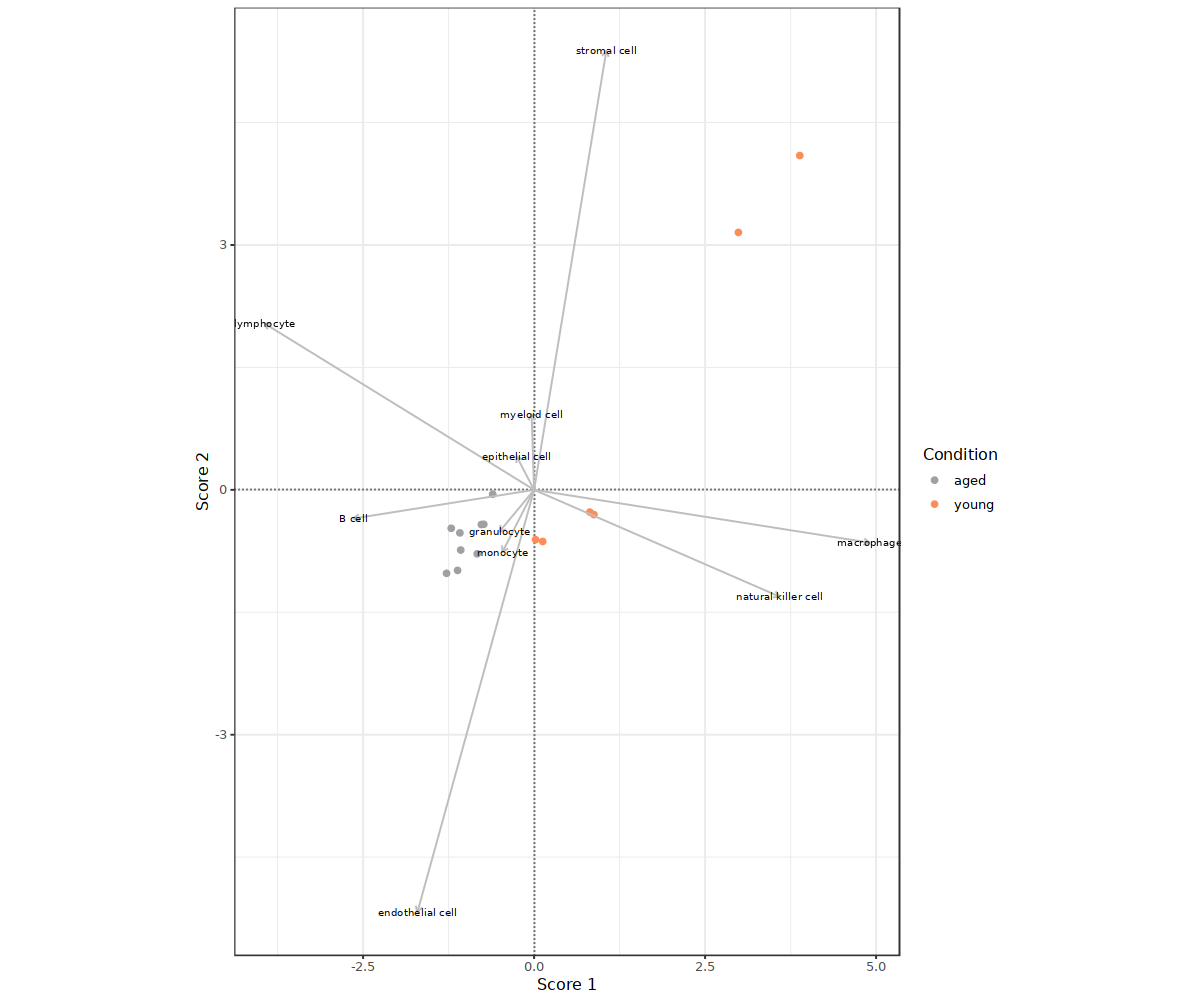

In [16]:
cao_obj$plotCodaSpace(space='CDA', font.size=2.5) 

In [17]:
cells.signif <- names(cao_obj$test.results$cda$pvals)[cao_obj$test.results$cda$pvals < signif.threshold]

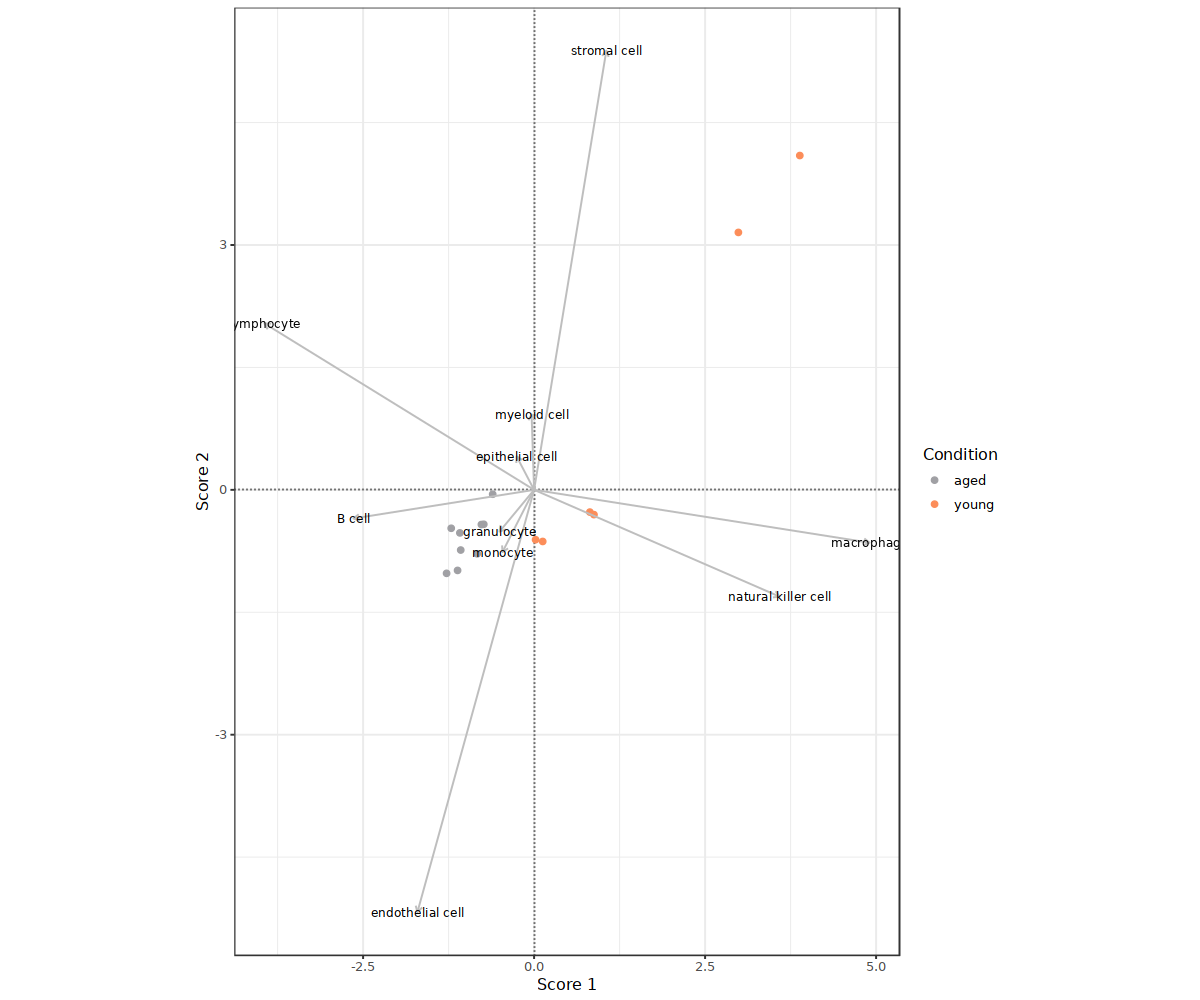

In [18]:
if(length(cells.signif) >= 2) {
 cao_obj$plotCodaSpace(space='CDA', cells.to.remain = cells.signif)
} else {
  cao_obj$plotCodaSpace(space='CDA')
}

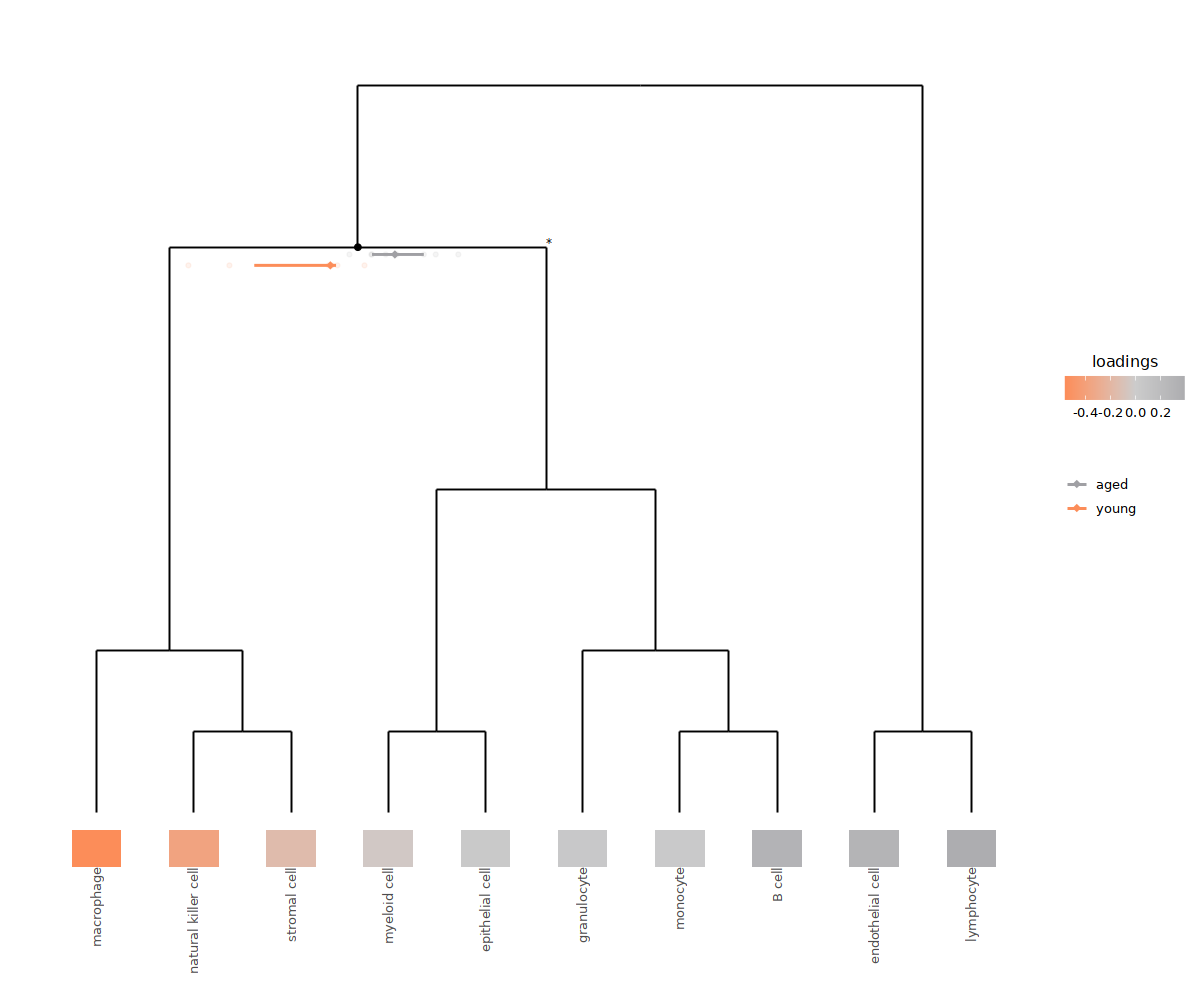

In [19]:
cao_obj$plotContrastTree()

In [20]:
library(ggplot2)


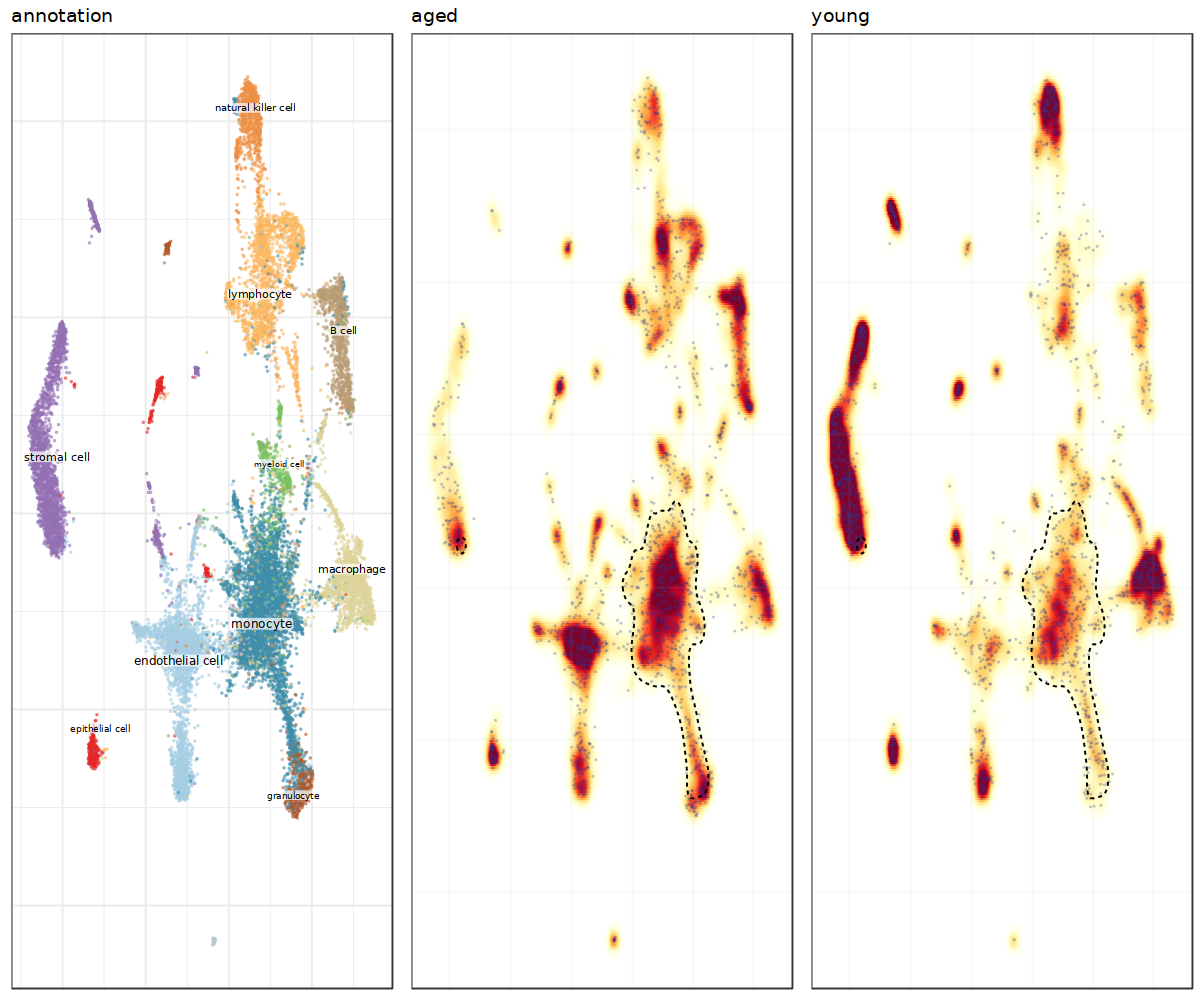

In [21]:

p0 <- cao_obj$plotEmbedding(color.by='cell.groups', alpha=alpha, size=size,
                        title='annotation', show.legend=FALSE, font.size=c(2,3))
pl <- cao_obj$plotCellDensity(add.points=TRUE, show.grid=TRUE, contours=cells.to.contour,
                          show.cell.groups=FALSE)
plot_grid(p0, plotlist=pl, nrow = 1)

Differential celld ensity calculates cluster free changes in density among the cells in the
UMAP plot, showing where cells are closely grouped in the plot

In [22]:
#cao_obj$estimateDiffCellDensity(type='permutation', verbose=FALSE)
p1 <- cao_obj$plotDiffCellDensity(type='permutation', title='difference',
                              legend.position=c(0,0), contours=cells.to.contour)

p3 <- cao_obj$plotDiffCellDensity(type='wilcox', title='wilcox',
                              legend.position=c(0,0), contours=cells.to.contour)
p4 <- cao_obj$plotDiffCellDensity(type='permutation', title='permutation',
                              legend.position=c(0,0), contours=cells.to.contour)

Warning message in cao_obj$plotDiffCellDensity(type = "wilcox", title = "wilcox", :
“Can't find results for name, 'cell.density' and type 'wilcox'. Running estimateDiffCellDensity with default parameters.”


ERROR: Error in mcfork(): unable to fork, possible reason: Cannot allocate memory


In [23]:
plot_grid(p0,p4)
plot_grid(p0,p3)
plot_grid(p0,p1)

ERROR: Error in plot_grid(p0, p4): object 'p4' not found


Cell density estimated on a graph based method

## Apln(R) testing

Cluster Free Differntial expression of Apln and AplnR

In [ ]:
if (snakemake@config[["organism"]] == "mm") {
    cao_obj$plotGeneExpressionComparison(genes = c("Apln", "Aplnr", "Cd74"), nrow = 2)
    VlnPlot(cao_obj$data.object, features = c("Apln"), idents = "endothelial cell", split.by = "binary_age")
    VlnPlot(cao_obj$data.object, features = c("Aplnr"), idents = "endothelial cell", split.by = "binary_age")
} else {
    cao_obj$plotGeneExpressionComparison(genes = c("APLN", "APLNR", "CD74"), nrow = 2)
    VlnPlot(cao_obj$data.object, features = c("APLN"), idents = "endothelial cell", split.by = "binary_age")
    VlnPlot(cao_obj$data.object, features = c("APLNR"), idents = "endothelial cell", split.by = "binary_age")

}


In [ ]:
  #  cao_obj$plotGeneExpressionComparison(genes = c("Apln", "Aplnr", "Cd74"), nrow = 2)
    VlnPlot(cao_obj$data.object, features = c("Apln","Aplnr"), idents = "endothelial cell", split.by = "binary_age",adjust = 0.5)
    VlnPlot(cao_obj$data.object, features = c("Aplnr"), idents = "endothelial cell", split.by = "binary_age", adjust  = 0.5)

The following plots show gene program scores and cluster free expression shifts in the data. 

In [ ]:
cao_obj$plotGeneProgramScores(legend.position=c(0, 1), size=0.1, alpha=0.1)

In [ ]:
plot_grid(
  cao_obj$plotClusterFreeExpressionShifts(size=0.1, alpha=0.1, legend.position=c(0, 0), font.size=c(2,3))
)

In [ ]:
plot_grid(plotlist=cao_obj$plotGeneProgramGenes(program.id = 1,plots = "z"), ncol = 3)

## Differential Gene Expression Analysis

Here 4 Different Methods were used for DE nalysis:
- de: DESE2 
- de.Fixed <- Fixed cell number (50), bootstrapped
- de.loo <- loo resampling method
- de.fix <- DESeq2 fix.count resampling

Plot differential expression using varios methods. 

In [ ]:

create_DE_plots <- function(de_type, cao_obj) {
    p_list <- list()
    print(de_type)

    p_list[["plot_volcano"]] <- cao_obj$plotVolcano(lf.cutoff = 0.5, name = de_type, build.panel = FALSE)
    p_list[["nDEgenes"]] <- cao_obj$plotNumberOfDEGenes(name=de_type,pvalue.cutoff=1e-3, p.adjust=FALSE,
                        show.jitter=FALSE, type='box', show.resampling.results=TRUE)
   #p_list[["go_map"]] <- cao_obj$plotOntologyHeatmapCollapsed(
  #name=paste0(de_type,"GO"), genes="all", n=50, clust.method="ward.D", size.range=c(1, 4)
 #  )

    p_list
}
plots <- lapply(list("de.Wald","deFixed_LRT", "de.fix", "de.loo"), create_DE_plots, cao_obj = cao_obj )
names(plots) <- c("de.Wald","deFixed_LRT", "de.fix", "de.loo")

In [ ]:
#plots[[4]]

if (save_plots) {
    cell_types <- names(plots[[4]]$plot_volcano)
    purrr::map(cell_types, function(x, y) {
        ggsave(glue::glue("{x}_volcanoplot.svg"), y[[x]] + ggtitle(x), path  = plot_path, width = 8, height = 8)
    },  y =plots[[4]]$plot_volcano)
}

In [ ]:
cao_obj$test.results$de.looGO$res <- purrr::map(cao_obj$test.results$de.looGO$res, function(x) {
    x$BP@result %>% dplyr::rename(qvalues = qvalue)
})
                                                

In [ ]:
go_plots <- list()
for(c_g in cao_obj$cell.groups %>% unique()) {
    try(go_plots[[c_g]]<-cao_obj$plotOntology(c_g, name = "de.looGO", title = c_g,font.size = 10, n = 15, size = "p.adjust", color = "NES")
)
}

In [ ]:
 #cao_obj$plotOntology("endothelial cell", name = "de.looGO")
go_plots
if (save_plots) {
    for (c_g in names(go_plots)){
        ggsave(filename = glue::glue("{c_g}_goplot.svg"), go_plots[[c_g]], path = plot_path, width = 8, height = 10)
    }
}
go_plots

In [ ]:
head(cao_obj$test.results$de.loo)

In [ ]:
#purrr::map(cao_obj$test.results$de.looGO$res, function(x) {
#    x$BP@result %>% dplyr::rename(qvalues = qvalue)
#})

In [ ]:
#head(cao_obj$test.results[["de.looGO"]])
